## GRAD CAM

This code implements GRAD CAM, the aim of the code is to test the algorithm on multiple CNN models. This code can take only a single image as input. 

In [1]:
## Import necessary libearies 

import tensorflow.compat.v1 as tf
import numpy as np
import keras
from keras import backend as K
from skimage import io
from skimage.transform import resize
from scipy.misc import imread, imresize
from keras.layers.core import Lambda
from keras.models import Sequential
from keras.models import Model
from matplotlib import pyplot as plt

tf.compat.v1.disable_eager_execution()
import cv2

2021-12-07 06:38:31.103550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/local/lib
2021-12-07 06:38:31.103572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


The working of GRAD CAM is tested using multiple Architectures 

In [2]:
# ## Uncomment the model that you want the code to work with 


InputModel = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# InputModel = tf.keras.applications.EfficientNetB0(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
# #     **kwargs
# )


# InputModel = tf.keras.applications.ResNet50(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#    # **kwargs
# )


# InputModel = tf.keras.applications.ResNet101(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#    # **kwargs
# )

2021-12-07 06:38:35.342732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sudarshan/Documents/Mobile Robotics/SMAI_project/SMAI/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/local/lib
2021-12-07 06:38:35.344593: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-07 06:38:35.344610: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sudarshan): /proc/driver/nvidia/version does not exist
2021-12-07 06:38:35.344817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable t

In [3]:
## Display the various layers in the input model note down the name of the final convolutional layer 

InputModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
## generating explanation maps for the water-bird image 


ImgPath = 'water-bird.JPEG'


img = imread(ImgPath, mode='RGB')
img = imresize(img, (224, 224))

x = np.expand_dims(img, axis=0) 
x = x[:,:,:,::-1]

/tmp/ipykernel_73746/3583825932.py:7: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(ImgPath, mode='RGB')
/tmp/ipykernel_73746/3583825932.py:8: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  img = imresize(img, (224, 224))


In [5]:
sess = tf.Session()
prob = InputModel.predict(x) ## Generate the Predictions Vector 

input_img =  x




/home/sudarshan/Documents/Mobile Robotics/SMAI_project/SMAI/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [6]:
predicted_class = np.argmax(prob) ## Get the predicted Class i.e. the class with the maximum prediction accuracy 


## According to the choosen model set appropriate name for the layer 
## EfficientNet = 'top_activation'
## VGG = 'block5_pool'
## Resnet50/101 = 'conv5_block3_out'

layer_name = 'block5_pool' 

NumClasses = np.shape(prob)[1]


In [7]:
# construct a loss function that returns the value at the output layer responsible for the given prediction  

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

In [8]:
def target_category_loss_output_shape(input_shape):
    return input_shape

In [9]:
target_layer = lambda x: target_category_loss(x, predicted_class, NumClasses)
x = Lambda(target_layer, output_shape = target_category_loss_output_shape)(InputModel.output)

model = Model(inputs=InputModel.input, outputs=x)

In [10]:
loss = K.sum(model.output)

for l in model.layers:
    
    if( l.name == layer_name ):
        conv_output = l.output

In [11]:
def normalize(x):
    # Get the L2 Norm of the input Tensor 
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [12]:
## The below code implements Eq. 11 in the paper (https://arxiv.org/pdf/1610.02391.pdf)
## TO determine the weights 


grads = normalize(K.gradients(loss, conv_output)[0])
gradient_function = K.function([model.layers[0].input], [conv_output, grads])

output, grads_val = gradient_function([input_img])
output = output[ 0 , :]
grads_val = grads_val[0 , :]

dim = np.shape(output)[0]
weights_k_c = np.mean( grads_val , axis=(0 , 1 ) )
localization_result = np.ones( (dim, dim) , dtype =np.float32 )

for i in range( len(weights_k_c)):
    localization_result += weights_k_c[i]*output[: , : , i]

cam = cv2.resize(localization_result, (224, 224))
cam = np.maximum(cam, 0)
heatmap = cam / np.max(cam)








## Visualization of Results 

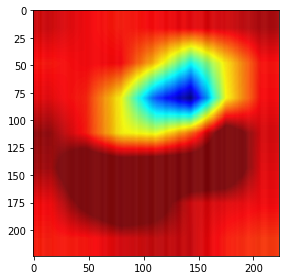

In [13]:
# Visulize the generated HeatMap

image = img[0, :]
image -= np.min(image)
image = np.minimum(image, 255)
cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
cam = 3*np.float32(cam) + np.float32(image)
cam = 255 * cam / np.max(cam)
cam = np.uint8(cam)


io.imshow(cam)
plt.show()




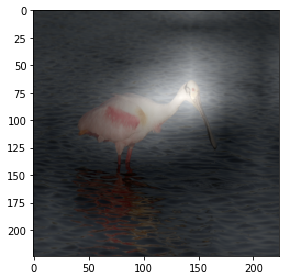

In [14]:
# Visulize the resulting Explanation Maps on the original image 

localization_result = np.maximum (localization_result , 0 )
localization_result = localization_result / np.max(localization_result)
localization_result = resize(localization_result, (224,224))
cam3 = np.expand_dims(localization_result, axis=2)
cam3 = np.tile(cam3,[1,1,3])
img = img.astype(float)
img /= img.max()
new_img = img+3*cam3
new_img /= new_img.max()

io.imshow(new_img)
plt.show()

## Save the resuting Maps

In [15]:
CAMSavePath = 'Results/water-bird_cam.png'
ExpSavePath = 'Results/water-bird_cam_Exp.png'

io.imsave(CAMSavePath , cam)
io.imsave(ExpSavePath , new_img)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
